In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pyro
from pyro.optim import Adam, ClippedAdam
from pyro.infer import TraceMeanField_ELBO, TraceEnum_ELBO, TraceGraph_ELBO, Trace_ELBO

import pandas as pd
import torch
import numpy as np

In [3]:
from locate.simulations.simulate import simulate_segment, simulate_data
from locate.simulations.utils_simulations import plot_simulations, create_input_simulations, plot_results_simulations

In [4]:
purity = 0.9
coverage = 50

segs = simulate_segment(only_clonal = True, 
                        purity = purity, 
                        coverage = coverage, 
                        genome_size = 1e8, 
                        segments = 5, 
                        CNA = ["1:1", "2:2", "2:1", "1:0", "3:1"])
segs

,id,start,end,len,coverage,SNP,SNV,purity,ploidy,Major_1,minor_1,Major_2,minor_2,ccf,type
0,0,0.0,23734219.0,23734219.0,50,1582,1582,0.9,3.280555,2,1,,,0,clonal
1,1,23734219.0,62715624.0,38981405.0,50,2598,2598,0.9,3.280555,2,1,,,0,clonal
2,2,62715624.0,77363220.0,14647596.0,50,976,976,0.9,3.280555,3,1,,,0,clonal
3,3,77363220.0,81977676.0,4614456.0,50,307,307,0.9,3.280555,1,1,,,0,clonal
4,4,81977676.0,99999997.0,18022321.0,50,1201,1201,0.9,3.280555,2,2,,,0,clonal


In [5]:
snp,snv = simulate_data(segs)
data_input, snp, snv = create_input_simulations(snp, snv)
ploidy = np.unique(segs.ploidy)[0]

In [6]:
# Create a copy of the DataFrame to avoid modifying the original
new_df = snp.copy()
new_df['logR'] = np.log2(new_df['dr'])

# Convert segID to chr (assumes segID starts from 0 and needs to be mapped to 1-based chromosome numbers)
new_df['chr'] = 1#new_df['segID'] + 1  # Adding 1 to convert 0-based to 1-based

# Create the new index in "chr:pos" format
new_df.index = new_df['chr'].astype(str) + ":" + new_df['pos'].astype(str)

# Rename the 'baf' column to 'BAF' to match the desired output
new_df.rename(columns={'baf': 'BAF'}, inplace=True)

# Select only the required columns in the desired order
result_df_baf = new_df[['chr', 'pos', 'BAF']]
result_df_dr = new_df[['chr', 'pos', 'logR']]



# Save to a file if needed
result_df_baf.to_csv('/Users/lucreziavaleriani/Desktop/sim.tumour.BAF.txt', sep='\t')
result_df_baf.to_csv('/Users/lucreziavaleriani/Desktop/sim.tumour.logR.txt', sep='\t')

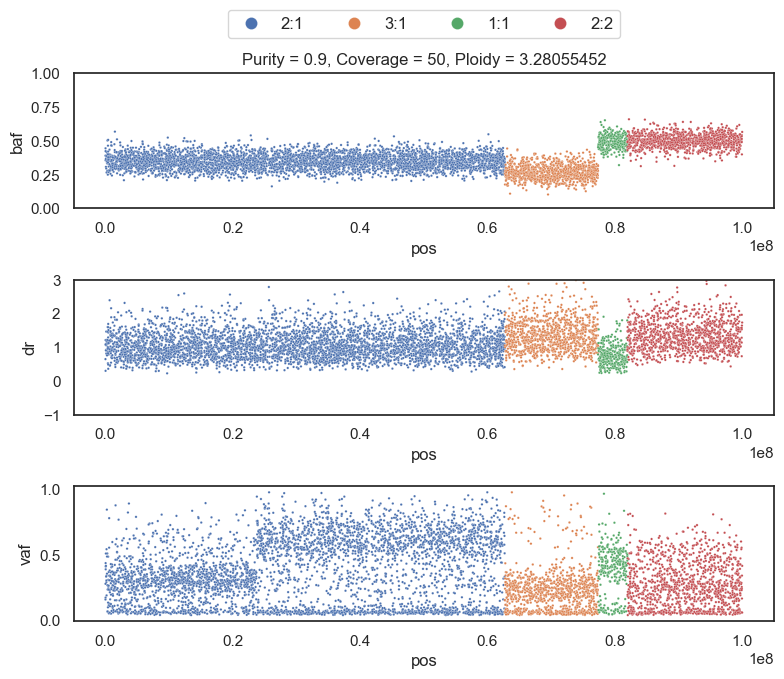

In [7]:
plot_simulations(snp, snv, purity, coverage, ploidy) 

In [8]:
import locate.locate as l
from locate.models import Clonal
from locate.utils import plot_loss

In [16]:
locate = l.LOCATE(CUDA = False)

locate.set_model(Clonal)
locate.set_optimizer(ClippedAdam)
locate.set_loss(TraceEnum_ELBO)
locate.initialize_model({"baf": data_input["baf"],
                         "dr": data_input["dr"], 
                         "dp_snp": data_input["dp_snp"], 
                         #"vaf": data_input["vaf"], 
                         #"dp": data_input["dp"]
                         })

locate.set_model_params({"jumping_prob" : 1e-6,
                         "fix_purity": True,
                         "fix_ploidy": False,
                         "prior_purity": purity,
                         "prior_ploidy": ploidy,
                         "scaling_factors": [1,10,1],
                         "hidden_dim":4, 
                         'init_probs': torch.tensor([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])})

In [17]:
ll = locate.run(steps = 300, param_optimizer = {"lr" : 0.05})

/Users/lucreziavaleriani/Documents/GitHub/locate/src/locate/models/Clonal.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor((1 - self._params["jumping_prob"]) * torch.eye(x.shape[0]) + self._params["jumping_prob"])
/Users/lucreziavaleriani/opt/anaconda3/envs/locate/lib/python3.11/site-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'mixture_idx'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")
/Users/lucreziavaleriani/opt/anaconda3/envs/locate/lib/python3.11/site-packages/pyro/infer/traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using T

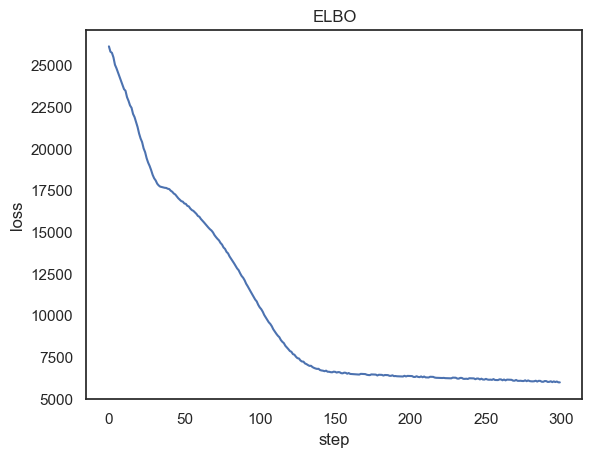

In [18]:
plot_loss(ll[0])


In [19]:
params = locate.learned_parameters_Clonal()

{'probs_x': tensor([[5.5737e-02, 7.8088e-12, 7.8088e-12, 2.0365e-11, 5.0623e-01, 1.4874e-01,
         7.8005e-12, 2.8929e-01, 6.4683e-12],
        [8.3540e-20, 1.0000e+00, 8.3540e-20, 8.3529e-20, 8.3540e-20, 8.3500e-20,
         8.3540e-20, 7.7732e-20, 8.0653e-20],
        [8.4657e-20, 8.4657e-20, 1.0000e+00, 8.4657e-20, 8.4657e-20, 8.4657e-20,
         8.4657e-20, 8.4640e-20, 8.4397e-20],
        [3.5571e-11, 3.7129e-11, 3.7129e-11, 3.9706e-01, 2.2586e-01, 1.9224e-02,
         1.6955e-01, 1.0789e-01, 8.0414e-02],
        [1.8653e-02, 2.8853e-11, 2.8854e-11, 5.1819e-02, 5.4218e-01, 1.2963e-01,
         2.8520e-11, 2.5754e-01, 1.8429e-04],
        [2.3807e-02, 2.8516e-11, 2.9078e-11, 2.8362e-02, 3.2528e-01, 4.1408e-01,
         2.9051e-11, 2.0822e-01, 2.4811e-04],
        [1.4883e-11, 1.4833e-11, 1.4833e-11, 1.8737e-01, 1.4491e-11, 1.4828e-11,
         4.9648e-01, 1.4753e-11, 3.1615e-01],
        [1.9135e-02, 4.4068e-11, 4.7922e-11, 5.7499e-02, 5.1322e-01, 1.5765e-01,
         4.1403e-1

In [20]:
try:
    print('Purity: ',params['purity'])
except:
    pass

try:
    print('Ploidy: ', params['ploidy'])
except:
    pass

Ploidy:  [3.4875364]


In [21]:
res = pd.DataFrame({'CN_Major':params["CN_Major"]+0.05,
                    'CN_minor':params["CN_minor"]-0.05,
                    'pos':[i for i in range(len(params["CN_minor"]))]})

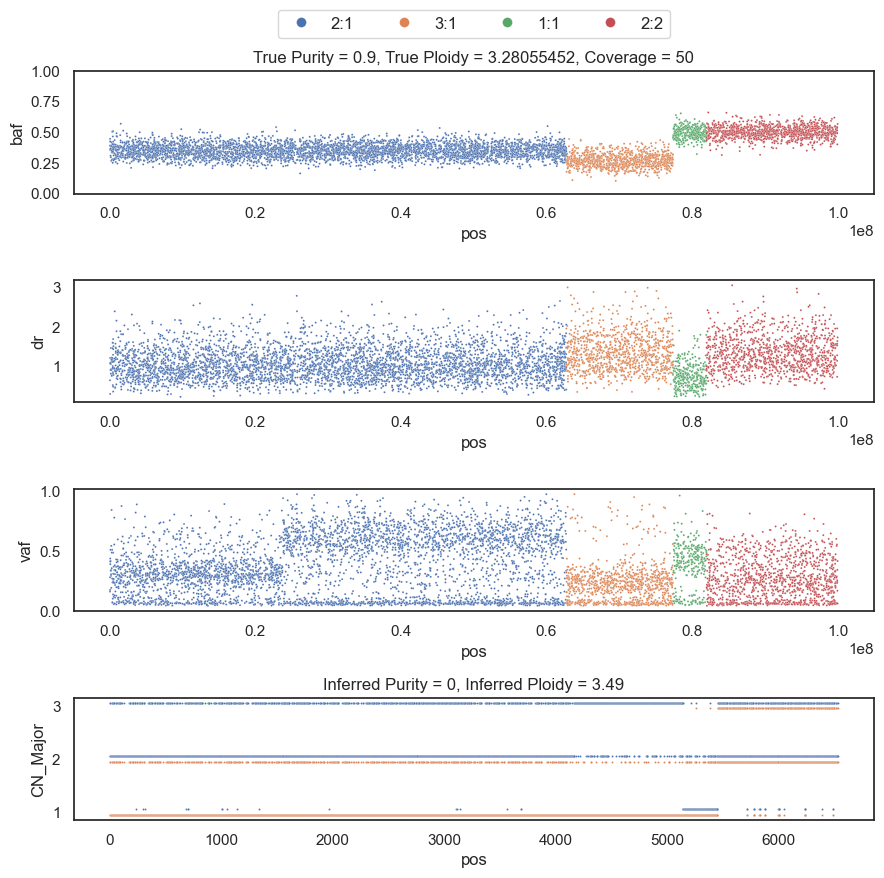

In [22]:
plot_results_simulations(snp, snv, res, params, purity, coverage, ploidy)